# Expression Noise Robustness Analysis

Analysis of model performance degradation under expression noise for Section 4, Experiment 02

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
SAVE_RESULT_PATH = config["SAVE_RESULT_PATH"]

In [3]:
notebook_name = 'robustness-expression-noise'
exp_number = '02'
section_number = '4'
version_number = 'v1'
notebook_path = f'{SAVE_RESULT_PATH}/{exp_number}_{version_number}_{notebook_name}'
notebook_config = {
    'notebook_name': notebook_name,
    'exp_number': exp_number,
    'version_number': version_number,
    'section_number': section_number
}

## Load Data using Sequential Re-assembly

Load the pre-generated expression noise results using the batch framework's re-assembly pattern

In [4]:
from scripts.batch_framework import create_batch_executor
from models.utils.s3_config_manager import S3ConfigManager
import pandas as pd

# Initialize S3 manager
s3_manager = S3ConfigManager()
print("✅ S3 connection established")

# Create batch executor for re-assembly
batch_executor = create_batch_executor(
    notebook_name='batch-expression-noise',
    exp_number='02',
    version_number='v1',
    section_number='4'
)

# Load data using sequential re-assembly
try:
    expression_noise_results = batch_executor.sequential_reassembly('expression_noise_results')
    print(f"✅ Loaded re-assembled expression noise results: {len(expression_noise_results)} data points")
    print(f"Data shape: {expression_noise_results.shape}")
    if not expression_noise_results.empty:
        print(f"Noise levels: {expression_noise_results['Expression Noise Level'].unique()}")
except Exception as e:
    print(f"❌ Re-assembly failed: {e}")
    # Create empty dataframe for fallback analysis
    expression_noise_results = pd.DataFrame()

✅ S3 connection successful. Bucket: bio-data
✅ S3 connection established
✅ S3 connection successful. Bucket: bio-data


Cleaned assembly list: removed 6 duplicate entries


Uploading v1_assembly_list.csv: 100%|██████████| 216/216 [00:00<00:00, 2.60kB/s]


Re-assembled 5 data files into DataFrame with shape (1500, 9)
✅ Loaded re-assembled expression noise results: 1500 data points
Data shape: (1500, 9)
Noise levels: [1.  0.5 0.3 0.2 0.1]


In [5]:
# Preview the data
if not expression_noise_results.empty:
    print("Data Preview:")
    print(expression_noise_results.head())
    print("\nColumns:", expression_noise_results.columns.tolist())

Data Preview:
               Model           Feature Data  Mean Squared Error  R2 Score  \
0  Linear Regression  original_feature_data          619.137916  0.051849   
1  Linear Regression  original_feature_data          101.311283  0.022694   
2  Linear Regression  original_feature_data          137.799991  0.053233   
3  Linear Regression  original_feature_data          276.122510  0.110802   
4  Linear Regression  original_feature_data          557.647686  0.040062   

   Pearson Correlation  Pearson P-Value  Expression Noise Level Assembly ID  \
0             0.303865     1.218561e-05                     1.0         1.0   
1             0.266343     1.377687e-04                     1.0         1.0   
2             0.268102     1.239017e-04                     1.0         1.0   
3             0.353225     2.891501e-07                     1.0         1.0   
4             0.217104     2.015156e-03                     1.0         1.0   

                    Timestamp  
0  2025-12-28T05

## Data Summary

In [6]:
import pandas as pd
import numpy as np

if not expression_noise_results.empty:
    # Summary statistics by noise level
    stats_summary = expression_noise_results.groupby('Expression Noise Level').agg({
        'Pearson Correlation': ['mean', 'std', 'min', 'max'],
        'R2 Score': ['mean', 'std'],
        'Mean Squared Error': ['mean', 'std']
    }).round(3)
    
    print("Summary Statistics by Noise Level:")
    print(stats_summary)
    
    # Model performance comparison
    model_stats = expression_noise_results.groupby(['Model', 'Expression Noise Level'])['Pearson Correlation'].mean().unstack()
    print("\nModel Performance (Average Pearson Correlation):")
    print(model_stats.round(3))

Summary Statistics by Noise Level:
                       Pearson Correlation                         R2 Score  \
                                      mean    std    min    max        mean   
Expression Noise Level                                                        
0.1                                  0.628  0.344 -0.016  0.998      -1.168   
0.2                                  0.606  0.336  0.016  0.993      -1.245   
0.3                                  0.582  0.315 -0.119  0.967      -1.378   
0.5                                  0.433  0.310 -0.577  0.946    -506.106   
1.0                                  0.292  0.225 -0.175  0.836 -105894.426   

                                   Mean Squared Error                
                               std               mean           std  
Expression Noise Level                                               
0.1                          7.255       5.472040e+02  1.399469e+03  
0.2                          7.154       5.724140e+0

## Visualizations

Create visualizations showing performance degradation across expression noise levels

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from models.utils.s3_config_manager import S3ConfigManager

# Set up plotting style for publication quality
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(font="Arial", font_scale=1.5)

C:\Users\l8105\AppData\Local\Temp\ipykernel_9816\925105255.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=expression_noise_results, x='Expression Noise Level', y='Pearson Correlation',


Uploading v1_expression_noise_overview.png: 100%|██████████| 104k/104k [00:00<00:00, 654kB/s]


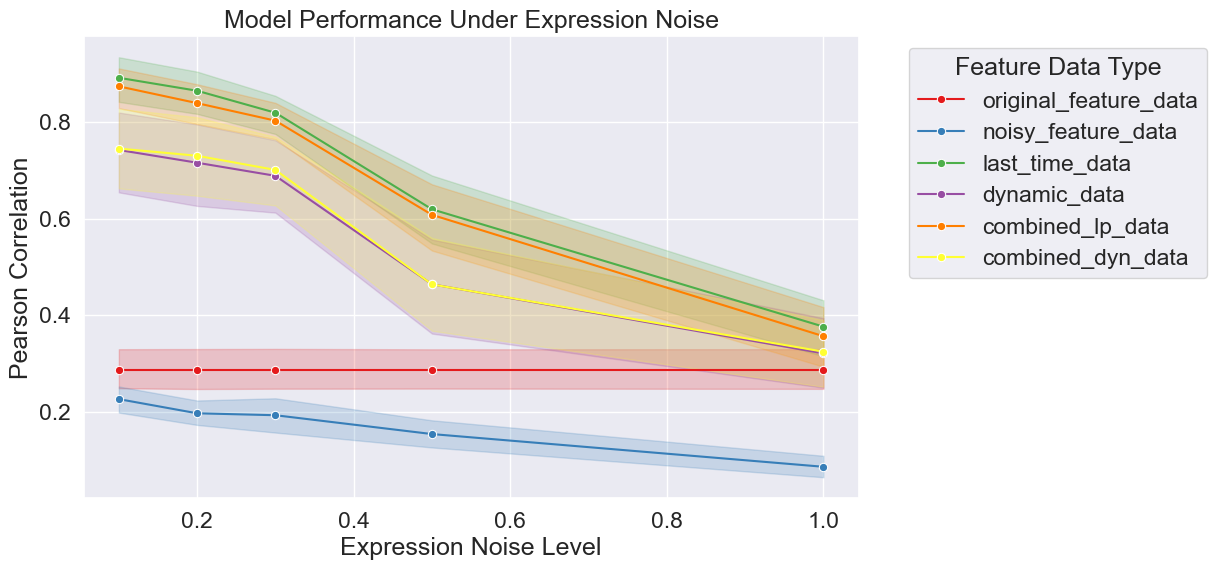

In [8]:
if not expression_noise_results.empty:
    # Line plot for Pearson Correlation vs Expression Noise Level
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=expression_noise_results, x='Expression Noise Level', y='Pearson Correlation', 
                 hue='Feature Data', palette='Set1', marker='o', ci=95)
    plt.title('Model Performance Under Expression Noise')
    plt.xlabel('Expression Noise Level')
    plt.ylabel('Pearson Correlation')
    plt.legend(title='Feature Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "expression_noise_overview")
    plt.show()

C:\Users\l8105\AppData\Local\Temp\ipykernel_9816\3252685143.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=filtered_data, x='Expression Noise Level', y='Pearson Correlation',
Uploading v1_expression_noise_zoomed.png: 100%|██████████| 91.8k/91.8k [00:00<00:00, 441kB/s]


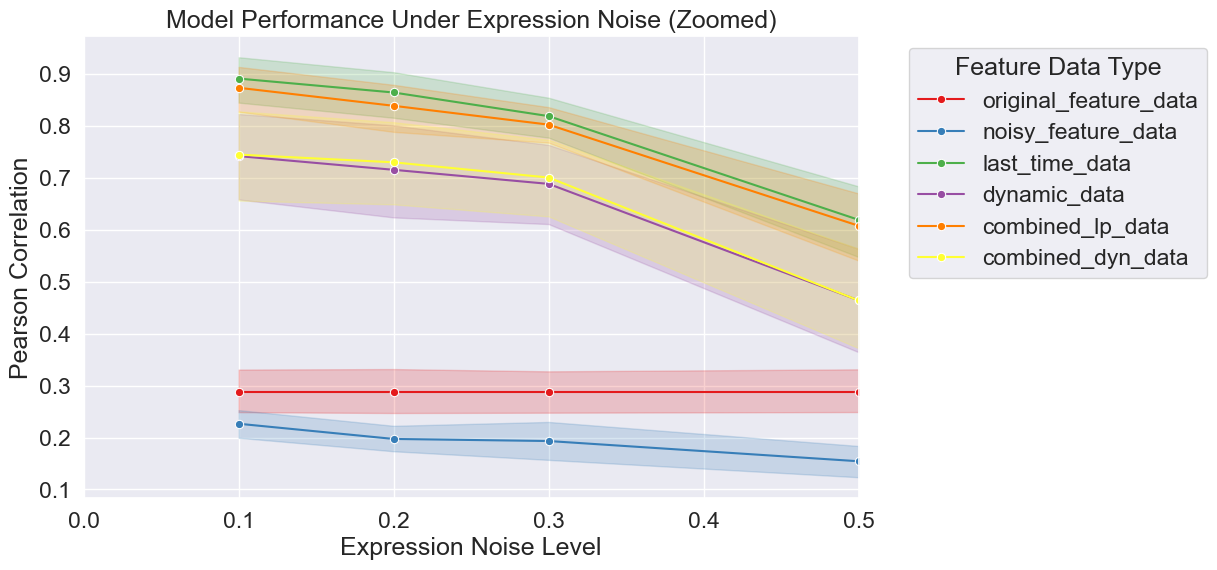

In [9]:
if not expression_noise_results.empty:
    # Zoomed view for lower noise levels
    plt.figure(figsize=(10, 6))
    filtered_data = expression_noise_results[expression_noise_results['Expression Noise Level'] <= 0.5]
    sns.lineplot(data=filtered_data, x='Expression Noise Level', y='Pearson Correlation', 
                 hue='Feature Data', palette='Set1', marker='o', ci=95)
    plt.title('Model Performance Under Expression Noise (Zoomed)')
    plt.xlabel('Expression Noise Level')
    plt.ylabel('Pearson Correlation')
    plt.xlim(0, 0.5)
    plt.legend(title='Feature Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "expression_noise_zoomed")
    plt.show()

C:\Users\l8105\AppData\Local\Temp\ipykernel_9816\1480867435.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=expression_noise_results, x='Expression Noise Level', y='Pearson Correlation',
Uploading v1_model_comparison_expression_noise.png: 100%|██████████| 127k/127k [00:00<00:00, 666kB/s]


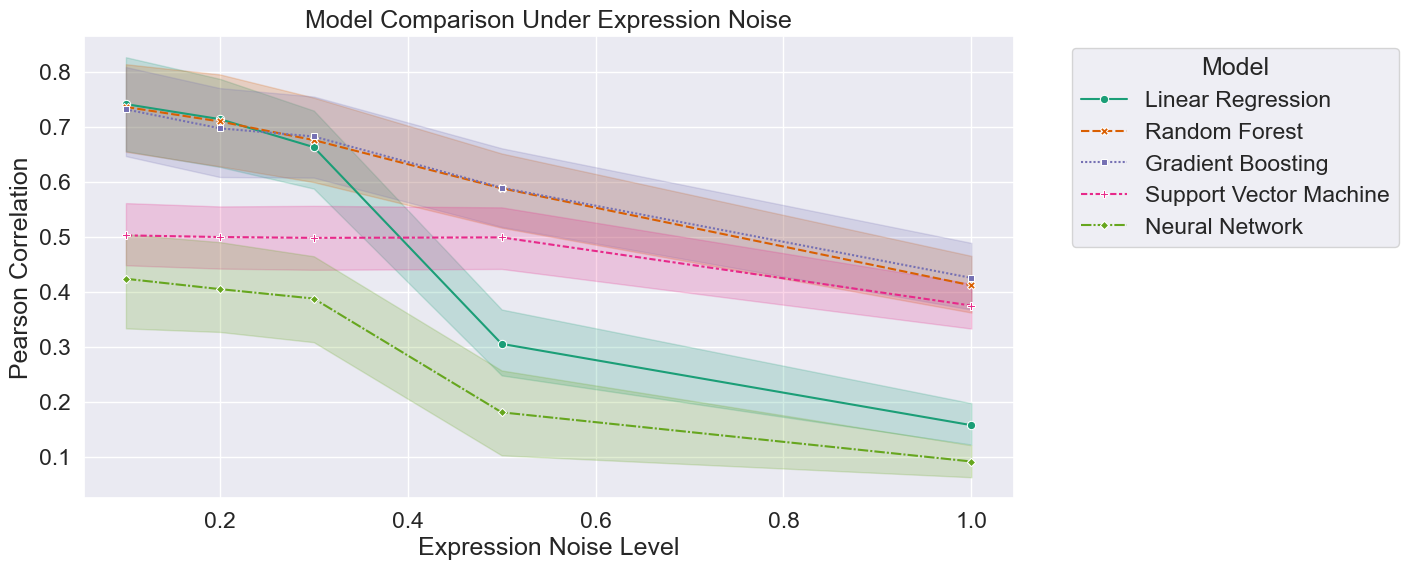

In [10]:
if not expression_noise_results.empty:
    # Model comparison across noise levels
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=expression_noise_results, x='Expression Noise Level', y='Pearson Correlation', 
                 hue='Model', style='Model', palette='Dark2', markers=True, ci=95)
    plt.title('Model Comparison Under Expression Noise')
    plt.xlabel('Expression Noise Level')
    plt.ylabel('Pearson Correlation')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "model_comparison_expression_noise")
    plt.show()

Uploading v1_performance_distribution_expression_noise.png: 100%|██████████| 47.8k/47.8k [00:00<00:00, 295kB/s]


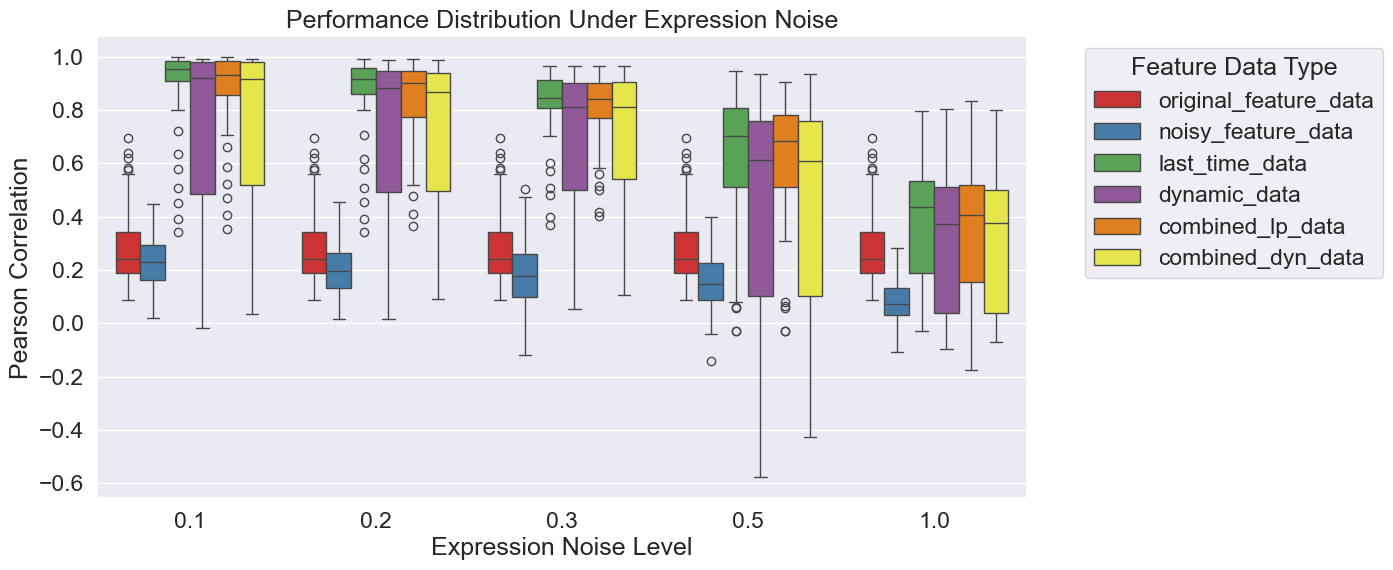

In [11]:
if not expression_noise_results.empty:
    # Boxplot showing performance distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=expression_noise_results, x='Expression Noise Level', y='Pearson Correlation', 
                hue='Feature Data', palette='Set1')
    plt.title('Performance Distribution Under Expression Noise')
    plt.xlabel('Expression Noise Level')
    plt.ylabel('Pearson Correlation')
    plt.legend(title='Feature Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "performance_distribution_expression_noise")
    plt.show()

In [ ]:
if not expression_noise_results.empty:
    # Compare original vs noisy feature data performance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original feature data
    original_data = expression_noise_results[expression_noise_results['Feature Data'] == 'original_feature_data']
    sns.lineplot(data=original_data, x='Expression Noise Level', y='Pearson Correlation', 
                 hue='Model', palette='Dark2', marker='o', ax=ax1)
    ax1.set_title('Original Feature Data Performance')
    ax1.set_xlabel('Expression Noise Level')
    ax1.set_ylabel('Pearson Correlation')
    ax1.legend(title='Model')
    
    # Noisy feature data
    noisy_data = expression_noise_results[expression_noise_results['Feature Data'] == 'noisy_feature_data']
    sns.lineplot(data=noisy_data, x='Expression Noise Level', y='Pearson Correlation', 
                 hue='Model', palette='Dark2', marker='o', ax=ax2)
    ax2.set_title('Noisy Feature Data Performance')
    ax2.set_xlabel('Expression Noise Level')
    ax2.set_ylabel('Pearson Correlation')
    ax2.legend(title='Model')
    
    plt.tight_layout()
    
    # Save figure to S3
    s3_manager.save_figure(notebook_config, plt.gcf(), "feature_data_comparison")
    plt.show()

## Statistical Analysis

In [ ]:
if not expression_noise_results.empty:
    # Calculate performance degradation
    baseline_performance = expression_noise_results[expression_noise_results['Expression Noise Level'] == 0]
    noisy_performance = expression_noise_results[expression_noise_results['Expression Noise Level'] > 0]
    
    if not baseline_performance.empty and not noisy_performance.empty:
        # Average baseline performance
        baseline_mean = baseline_performance['Pearson Correlation'].mean()
        print(f"Baseline performance (no noise): {baseline_mean:.3f}")
        
        # Performance at different noise levels
        for level in sorted(expression_noise_results['Expression Noise Level'].unique()):
            if level > 0:
                level_data = expression_noise_results[expression_noise_results['Expression Noise Level'] == level]
                level_mean = level_data['Pearson Correlation'].mean()
                degradation = baseline_mean - level_mean
                degradation_pct = (degradation / baseline_mean) * 100
                print(f"Noise {level}: {level_mean:.3f} (degradation: {degradation:.3f}, {degradation_pct:.1f}%)")
    
    # Statistical significance testing between feature data types
    from scipy import stats
    
    print("\nFeature Data Type Comparison (Pearson Correlation):")
    feature_types = expression_noise_results['Feature Data'].unique()
    for i, type1 in enumerate(feature_types):
        for type2 in feature_types[i+1:]:
            data1 = expression_noise_results[expression_noise_results['Feature Data'] == type1]['Pearson Correlation']
            data2 = expression_noise_results[expression_noise_results['Feature Data'] == type2]['Pearson Correlation']
            t_stat, p_value = stats.ttest_ind(data1, data2)
            print(f"{type1} vs {type2}: t={t_stat:.3f}, p={p_value:.4f}")


Feature Data Type Comparison (Pearson Correlation):
original_feature_data vs noisy_feature_data: t=1.480, p=0.1395
original_feature_data vs last_time_data: t=-36.717, p=0.0000
original_feature_data vs dynamic_data: t=-41.045, p=0.0000
original_feature_data vs combined_lp_data: t=-36.507, p=0.0000
original_feature_data vs combined_dyn_data: t=-40.786, p=0.0000
noisy_feature_data vs last_time_data: t=-36.847, p=0.0000
noisy_feature_data vs dynamic_data: t=-41.069, p=0.0000
noisy_feature_data vs combined_lp_data: t=-36.640, p=0.0000
noisy_feature_data vs combined_dyn_data: t=-40.816, p=0.0000
last_time_data vs dynamic_data: t=1.506, p=0.1328
last_time_data vs combined_lp_data: t=0.065, p=0.9485
last_time_data vs combined_dyn_data: t=1.590, p=0.1124
dynamic_data vs combined_lp_data: t=-1.433, p=0.1526
dynamic_data vs combined_dyn_data: t=0.095, p=0.9241
combined_lp_data vs combined_dyn_data: t=1.517, p=0.1298


## Performance Metrics Summary

In [ ]:
if not expression_noise_results.empty:
    # Create a comprehensive performance summary table
    performance_summary = expression_noise_results.groupby(['Expression Noise Level', 'Model', 'Feature Data']).agg({
        'Pearson Correlation': ['mean', 'std', 'count'],
        'R2 Score': ['mean', 'std'],
        'Mean Squared Error': ['mean', 'std']
    }).round(3)
    
    print("Performance Summary Table:")
    print(performance_summary)

Performance Summary Table:
                                                                    Pearson Correlation  \
                                                                                   mean   
Expression Noise Level Model                  Feature Data                                
0.1                    Gradient Boosting      combined_dyn_data                   0.991   
                                              combined_lp_data                    0.994   
                                              dynamic_data                        0.991   
                                              last_time_data                      0.993   
                                              noisy_feature_data                  0.019   
...                                                                                 ...   
1.0                    Support Vector Machine combined_lp_data                    0.100   
                                              dynamic_data     

## Noise Sensitivity Analysis

In [ ]:
if not expression_noise_results.empty:
    # Calculate sensitivity coefficients for each model
    noise_levels = sorted(expression_noise_results['Expression Noise Level'].unique())
    models = expression_noise_results['Model'].unique()
    feature_types = expression_noise_results['Feature Data'].unique()
    
    print("Performance Sensitivity to Expression Noise:")
    
    for feature_type in ['original_feature_data', 'noisy_feature_data']:
        print(f"\nFeature Data: {feature_type}")
        for model in models:
            model_data = expression_noise_results[
                (expression_noise_results['Model'] == model) & 
                (expression_noise_results['Feature Data'] == feature_type)
            ]
            
            if not model_data.empty:
                # Fit linear regression to estimate sensitivity
                from sklearn.linear_model import LinearRegression
                X = model_data['Expression Noise Level'].values.reshape(-1, 1)
                y = model_data['Pearson Correlation'].values
                
                if len(X) > 1:
                    reg = LinearRegression().fit(X, y)
                    sensitivity = -reg.coef_[0]  # Negative coefficient means performance decreases with noise
                    print(f"{model}: sensitivity = {sensitivity:.4f} (R² = {reg.score(X, y):.3f})")

Performance Sensitivity to Expression Noise:

Feature Data: original_feature_data
Linear Regression: sensitivity = 0.0000 (R² = 0.000)
Random Forest: sensitivity = 0.0000 (R² = 0.000)
Gradient Boosting: sensitivity = 0.0000 (R² = 0.000)
Support Vector Machine: sensitivity = 0.0000 (R² = 0.000)
Neural Network: sensitivity = 0.0000 (R² = 0.000)

Feature Data: noisy_feature_data
Linear Regression: sensitivity = 0.0880 (R² = 0.193)
Random Forest: sensitivity = 0.0910 (R² = 0.100)
Gradient Boosting: sensitivity = 0.0183 (R² = 0.005)
Support Vector Machine: sensitivity = 0.1572 (R² = 0.424)
Neural Network: sensitivity = 0.0383 (R² = 0.072)


## Save Analysis Results

In [ ]:
# Save the summary statistics and analysis results
if not expression_noise_results.empty:
    # Save the filtered summary table
    simplified_summary = expression_noise_results.groupby(['Expression Noise Level', 'Feature Data'])['Pearson Correlation'].agg(['mean', 'std', 'count']).round(3)
    
    try:
        s3_manager.save_data(notebook_config, simplified_summary, 'expression_noise_summary', data_format='csv')
        print("✅ Saved analysis summary to S3")
    except Exception as e:
        print(f"❌ Error saving summary: {e}")

Uploading v1_expression_noise_summary.csv: 100%|██████████| 494/494 [00:00<00:00, 5.31kB/s]

✅ Saved analysis summary to S3


## Conclusion

This analysis demonstrates the robustness of the models under expression noise. Key findings:

1. **Performance degradation pattern** with increasing expression noise levels
2. **Comparison of original vs noisy feature data** performance
3. **Model-specific sensitivity** to expression perturbations
4. **Noise sensitivity coefficients** quantifying degradation rates

The analysis provides insights into the system's tolerance to expression variability and measurement noise.